## American Style Options (DRAFT)

### 1 Theory

\begin{equation}
V(t)=\sup_{\tau\in\mathcal{T}_{t,T}}\mathbb{E}_{\mathbb{Q}}\left(\frac{B(t)}{B(\tau)}g(\tau,S_{\tau})\bigg|\mathcal{F}_t\right)
\tag{1}
\end{equation}

\begin{equation}
Z(t,S_t)=\begin{cases} 
      g(t,S_t) & \mathrm{if}\,t=t_N=T \\
      \max(g(t,S_t),c(t,S_t)) &  \mathrm{if}\,0\leq t\leq t_{N-1} 
   \end{cases}
\tag{2}
\end{equation}

\begin{equation}
c(t_i,S_{i})=\mathbb{E}_{\mathbb{Q}}\left(\frac{B(t_i)}{B(t_{i+1})}g(t_{i+1},S_{t_{i+1}})\bigg|\mathcal{F}_{t_i}\right)
\tag{3}
\end{equation}

\begin{equation}
\tau^*(\omega)=\inf\left\{s\big|s\geq t\wedge Z(t,S_t(\omega))=g(t,S_t(\omega))\right\}
\tag{4}
\end{equation}

### 2 The Longstaff-Schwartz algorithm

In [1]:
from context import *

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product as cartesian_product
from controller.controller import SimulationController
from models.black_scholes import BlackScholesModel
from metrics.pv_metric import PVMetric
from metrics.epe_metric import EPEMetric
from metrics.pfe_metric import PFEMetric
from products.bermudan_option import AmericanOption, OptionType
from products.european_option import EuropeanOption
from products.equity import Equity
from engine.engine import SimulationScheme

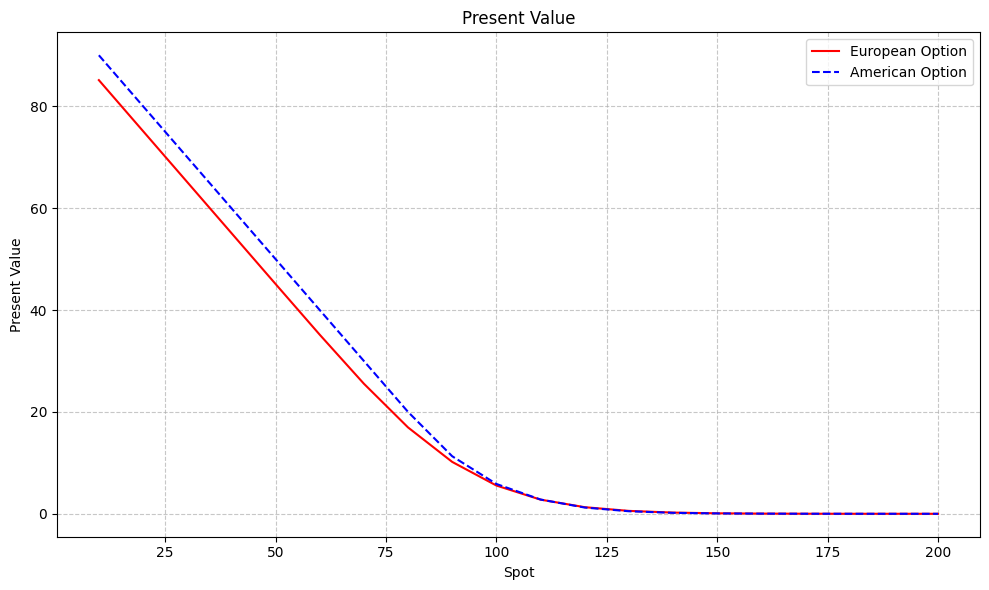

In [2]:
# Define parameter grid
S0_vals = np.linspace(10, 200, 20)
sigma_vals = [0.2]
r_vals = [0.05]
strikes = [100]
T_vals = [1.0]

# Cartesian product of all combinations
# defining the parameter grid
param_grid = list(cartesian_product(T_vals,S0_vals, sigma_vals, r_vals, strikes))

num_paths_main_sim = 100000
num_paths_pre_sim = 10000
steps = 1

def compute_pv_wrapper(args):
    spot, rate, vola = args
    model = BlackScholesModel(0, spot, rate, vola)

    underlying = Equity('id')
    ao = AmericanOption(underlying, 1.0, 10, 100, OptionType.PUT)
    eo = EuropeanOption(underlying, 1.0, 100, OptionType.PUT)

    portfolio = [ao, eo]
    metrics = [PVMetric()]

    sc = SimulationController(
        portfolio,
        model,
        metrics,
        num_paths_main_sim,
        num_paths_pre_sim,
        steps,
        SimulationScheme.ANALYTICAL,
        False
    )

    sim_results = sc.run_simulation()
    pv_ao = sim_results.get_results(0, 0)[0]
    pv_eo = sim_results.get_results(1, 0)[0]
    
    return [pv_ao, pv_eo]

# Create parameter grid and run simulation
deriv_param_grid = list(cartesian_product(S0_vals, r_vals, sigma_vals))
pvs = np.array([compute_pv_wrapper(params) for params in deriv_param_grid])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S0_vals, pvs[:, 1], label='European Option', color='red')
plt.plot(S0_vals, pvs[:, 0], label='American Option', color='blue', linestyle='--')

plt.xlabel('Spot')
plt.ylabel('Present Value')
plt.title('Present Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

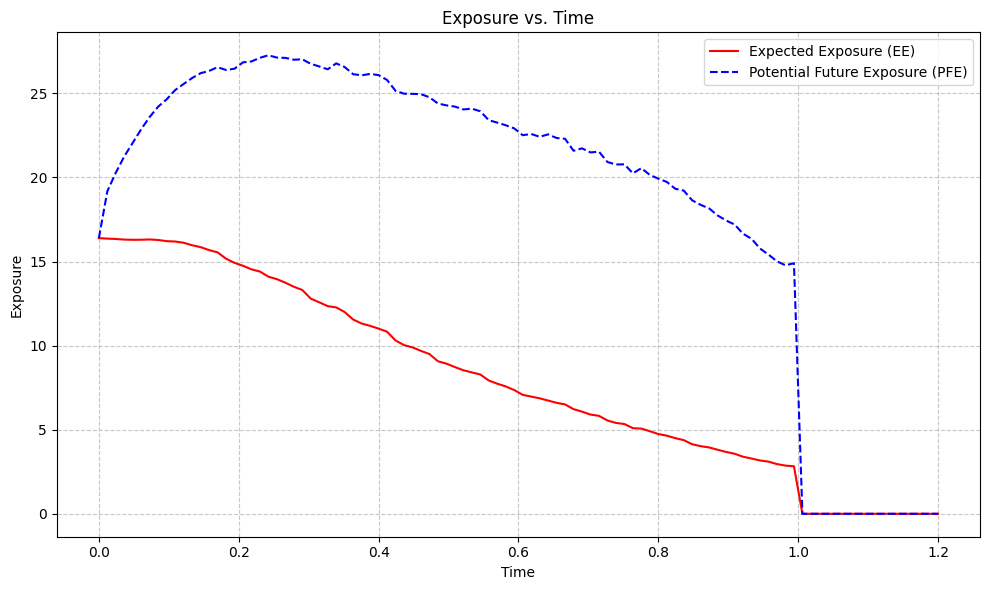

In [3]:
model = BlackScholesModel(calibration_date=0.0, spot=100, rate=0.05, sigma=0.5)
maturity = 1.0
strike = 100.0

underlying = Equity('id')
ao1 = AmericanOption(underlying=underlying, maturity=maturity, num_exercise_dates=10, strike=strike, option_type=OptionType.PUT)
ao2 = AmericanOption(underlying=underlying, maturity=maturity, num_exercise_dates=20, strike=strike, option_type=OptionType.PUT)
ao3 = AmericanOption(underlying=underlying, maturity=maturity, num_exercise_dates=100, strike=strike, option_type=OptionType.PUT)

portfolio=[ao1,ao2,ao3]

# Metric timeline for EE
exposure_timeline = np.linspace(0, 1.2,100)
ee_metric = EPEMetric()
pfe_metric = PFEMetric(0.9)

metrics=[ee_metric, pfe_metric]

num_paths_mainsim=10000
num_paths_presim=10000
num_steps=1
sc=SimulationController(portfolio, model, metrics, num_paths_mainsim, num_paths_presim, num_steps, SimulationScheme.ANALYTICAL, False, exposure_timeline)

sim_results=sc.run_simulation()

plt.figure(figsize=(10, 6))
plt.plot(exposure_timeline, sim_results.get_results(2,0), label='Expected Exposure (EE)', color='red')
plt.plot(exposure_timeline, sim_results.get_results(2,1), label='Potential Future Exposure (PFE)', color='blue', linestyle='--')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Exposure')
plt.title('Exposure vs. Time')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Optional: Tight layout
plt.tight_layout()

# Show the plot
plt.show()

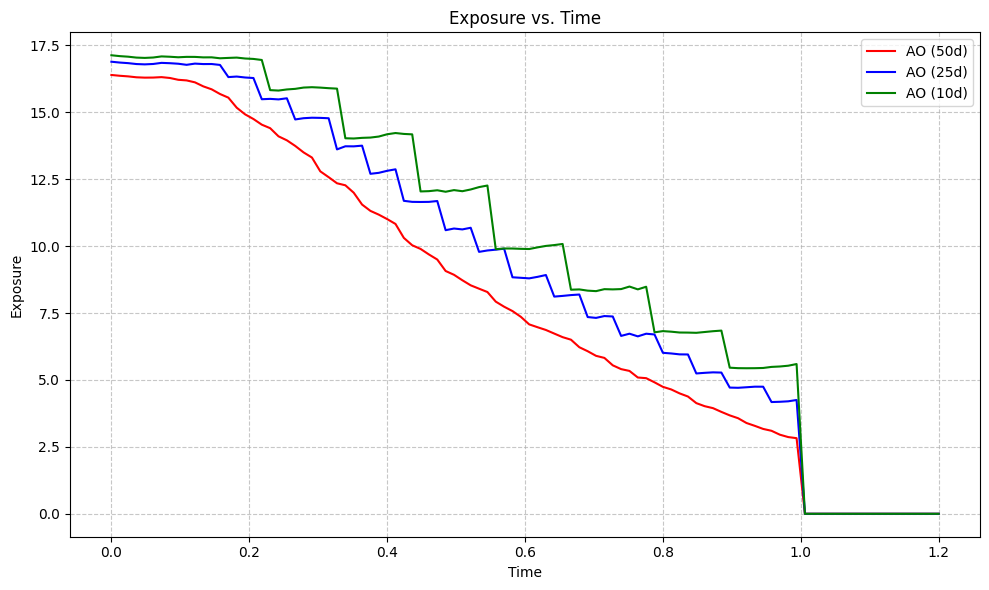

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(exposure_timeline, sim_results.get_results(2,0), label='AO (50d)', color='red')
plt.plot(exposure_timeline, sim_results.get_results(1,0), label='AO (25d)', color='blue')
plt.plot(exposure_timeline, sim_results.get_results(0,0), label='AO (10d)', color='green')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Exposure')
plt.title('Exposure vs. Time')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Optional: Tight layout
plt.tight_layout()

# Show the plot
plt.show()

### 3 Pricing via Deep Reinforcement Learning

In [5]:
from models.model import Model
from models.vasicek import VasicekModel
from products.swap import InterestRateSwap, IRSType
from engine.engine import MonteCarloEngine, SimulationScheme
from products.bermudan_option import BermudanOption, OptionType
from request_interface.request_interface import RequestInterface
from collections import deque
from torch import nn
import torch
import random

FLOAT = torch.float32
K = 100  # Strike price
r = 0.05
sigma = 0.2
S0 = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Environment:
    def __init__(self, state_dim, action_dim):
        self.state = torch.zeros(state_dim, dtype=FLOAT)
        self.state_dim = state_dim
        self.action_dim = action_dim

    def reset(self):
        self.state = torch.zeros(self.state_dim, dtype=FLOAT)
        return self.state.clone()

    def step(self, action):
        raise NotImplementedError


class AmericanOptionEnv(Environment):
    """
    Minimal CartPole with discrete actions: 0 = push left, 1 = push right
    Reward: +1 per time step until failure. Episode ends when thresholds exceeded.
    Dynamics integrated via RK4.
    """
    def __init__(self, american_option: AmericanOption, model: Model, simulation_scheme=SimulationScheme.ANALYTICAL, num_steps=1):
        super().__init__(state_dim=2, action_dim=2)
        self.american_option = american_option
        self.model = model
        self.time_idx = 0
        
        self.request_interface = RequestInterface(self.model)
        
        self.request_interface.collect_and_index_requests([self.american_option], self.american_option.product_timeline, {}, [])
        
        # Instantiate Monte Carlo engine to simulate paths in the main simulation phase
        self.engine = MonteCarloEngine(
            simulation_timeline=self.american_option.product_timeline,
            simulation_type=simulation_scheme,
            model=self.model,
            num_paths=1,
            num_steps=num_steps,
            is_pre_simulation=False
        )

    def _reset_state(self):
        return torch.tensor([0, 0.], dtype=FLOAT)
        
    def reset(self):
        self.time_idx = 0
        
        # Generate Monte Carlo paths
        self.paths=self.engine.generate_paths()

        # Resolve product and exposure requests 
        self.resolved_requests = self.request_interface.resolve_requests(self.paths)
        
        spot = self.resolved_requests[1][self.american_option.underlying_requests[self.time_idx].get_handle()][0]
        K = self.american_option.strike
        self.state = torch.tensor([self.time_idx, spot / K], dtype=FLOAT)
        
        return self.state.clone()

    def step(self, action):
        is_last = self.time_idx == len(self.american_option.product_timeline) - 1
        spot = self.resolved_requests[1][self.american_option.underlying_requests[self.time_idx].get_handle()][0]
        K = self.american_option.strike

        if action == 1:  # Chose to exercise early
            reward = self.american_option.payoff(spot, None)
            numeraire = self.resolved_requests[0][self.american_option.numeraire_requests[self.time_idx].handle][0]
            normalized_reward = reward / numeraire
            self.state = self._reset_state()
            done = True

        elif is_last:
            # Automatically exercise if any intrinsic value remains
            reward = self.american_option.payoff(spot, None)
            numeraire = self.resolved_requests[0][self.american_option.numeraire_requests[self.time_idx].handle][0]
            normalized_reward = reward / numeraire
            done = True
            self.state = self._reset_state()

        else:  # Hold and continue
            normalized_reward = 0
            self.time_idx += 1
            spot_next = self.resolved_requests[1][self.american_option.underlying_requests[self.time_idx].get_handle()][0]
            self.state = torch.tensor([self.time_idx, spot_next / K], dtype=FLOAT)
            done = False
        return self.state.clone(), normalized_reward, done


# ----------------------------
# DQN Agent
# ----------------------------
class DQLAgent:
    def __init__(
        self,
        environment: Environment,
        hidden_dim=128,
        lr=1e-3,
        gamma=1,
        replay_capacity=50_000,
        batch_size=64,
        num_episodes=10000
    ):
        self.environment = environment
        self.state_dim = environment.state_dim
        self.action_dim = environment.action_dim
        self.gamma = gamma

        # Epsilon-greedy schedule
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        self.replay_buffer = deque(maxlen=replay_capacity)
        self.batch_size = batch_size
        self.num_episodes = num_episodes

        # Device
        self.device = torch.device("cpu")

        self.hidden_dim = hidden_dim
        self.q_network = self._create_model().to(self.device)
        self.target_network = self._create_model().to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # Target update (soft)
        self.tau = 0.005
        
    def _create_model(self):
        q_net = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.action_dim),
        )
        return q_net

    @torch.no_grad()
    def select_action(self, state_tensor):
        """
        state_tensor: shape (state_dim,) on device
        """
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        q_vals = self.q_network(state_tensor.unsqueeze(0))  # (1, A)
        action = int(q_vals.argmax(dim=1).item())
        return action

    def _soft_update(self):
        with torch.no_grad():
            for p_t, p in zip(self.target_network.parameters(), self.q_network.parameters()):
                p_t.data.mul_(1 - self.tau).add_(self.tau * p.data)

    def replay(self):
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states_tensor = torch.stack(states).to(self.device)                    # (B, S)
        actions_tensor = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)  # (B,1)
        rewards_tensor = torch.tensor(rewards, dtype=FLOAT, device=self.device).unsqueeze(1)  # (B,1)
        dones_tensor = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)  # (B,1)

        # Compute target Q
        with torch.no_grad():
            # Double DQN: use online net to choose, target net to evaluate
            next_q_online = self.q_network(next_states_tensor := torch.stack(next_states).to(self.device))  # (B,A)
            next_actions = next_q_online.argmax(dim=1, keepdim=True)  # (B,1)
            next_q_target = self.target_network(next_states_tensor).gather(1, next_actions)  # (B,1)
            target_q = rewards_tensor + (~dones_tensor).float() * self.gamma * next_q_target  # (B,1)

        # Current Q
        q_vals = self.q_network(states_tensor)  # (B,A)
        q_sa = q_vals.gather(1, actions_tensor)  # (B,1)

        loss = self.criterion(q_sa, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10.0)
        self.optimizer.step()

        # Soft update target
        self._soft_update()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.epsilon_min)

        return float(loss.item())

    def train(self, warmup=1000):
        step_count = 0
        episode_rewards = []

        for ep in range(self.num_episodes):
            state = self.environment.reset().to(self.device)
            done = False
            total_reward = 0.0

            for _ in range(self.num_episodes):
                action = self.select_action(state)
                next_state, reward, done = self.environment.step(action)
                next_state = next_state.to(self.device)

                self.replay_buffer.append(
                    (state.detach().cpu(), action, float(reward), next_state.detach().cpu(), done)
                )

                state = next_state
                total_reward += float(reward)
                step_count += 1

                # Learn
                if len(self.replay_buffer) >= self.batch_size and step_count > warmup:
                    self.replay()

                if done:
                    break

            episode_rewards.append(total_reward)

            if ep % 1000 == 0 or ep == self.num_episodes - 1:
                avg = sum(episode_rewards[-1000:]) / min(1000, len(episode_rewards))
                print(f"Episode {ep+1}/{self.num_episodes} | epsilon={self.epsilon:.3f} | avg_reward={avg:.4f}")

        return episode_rewards

    @torch.no_grad()
    def test(self, episodes=10):
        self.q_network.eval()
        pv = 0.0
        for episode in range(episodes):
            state = self.environment.reset().to(self.device)
            done = False
            total_reward = 0.0
            steps = 0
            while not done:
                q_values = self.q_network(state.unsqueeze(0))
                action = int(q_values.argmax(dim=1).item())
                state, reward, done = self.environment.step(action)
                state = state.to(self.device)
                total_reward += float(reward)
                steps += 1
            pv = pv + total_reward
        return pv / episodes
                
model = BlackScholesModel(0, S0, r, sigma)

underlying = Equity('id')
strike = 100.0
exercise_dates = [0.5,1.0,1.5,2.0,2.5]

bo = BermudanOption(underlying,exercise_dates,strike,OptionType.PUT)

american_opt_env = AmericanOptionEnv(bo, model)

agent = DQLAgent(american_opt_env, num_episodes=10000)
agent.train()
pv = agent.test(episodes=10000)
print(f"PV American Equity Option (DQN): {pv:.4f}")

portfolio = [bo]
metrics=[PVMetric()]

sc=SimulationController(portfolio, model, metrics, 1000000, 100000, 1, SimulationScheme.ANALYTICAL, True)

sim_results=sc.run_simulation()
pv_engine=sim_results.get_results(0,0)[0]
print(f"PV American Equity Option (LSM): {pv_engine:.4f}")

model = VasicekModel(calibration_date=0.,rate=0.03,mean=0.05,mean_reversion_speed=0.002,volatility=0.2)
exercise_dates = [2.0]
maturity = 3.0
strike = 0.01

underlying = InterestRateSwap(startdate=0.0,
                                enddate=maturity,
                                notional=1.0,
                                fixed_rate=0.03,
                                tenor_fixed=0.25,
                                tenor_float=0.25, 
                                irs_type=IRSType.RECEIVER)

product = BermudanOption(underlying=underlying, 
                            exercise_dates=exercise_dates, 
                            strike=strike, 
                            option_type=OptionType.PUT)

american_opt_env = AmericanOptionEnv(product, model, simulation_scheme=SimulationScheme.EULER, num_steps=100)

agent = DQLAgent(american_opt_env, num_episodes=10000)
agent.train()
pv = agent.test(episodes=10000)
print(f"PV Bermudan Swaption (DQN): {pv:.4f}")

portfolio = [product]
metrics=[PVMetric()]

sc=SimulationController(portfolio, model, metrics, 1_000_000, 1_000_000, 100, SimulationScheme.EULER, False)

sim_results=sc.run_simulation()
pv_engine=sim_results.get_results(0,0)[0]
print(f"PV Bermudan Swaption (LSM): {pv_engine:.4f}")

Episode 1/10000 | epsilon=1.000 | avg_reward=0.0000
Episode 1001/10000 | epsilon=0.010 | avg_reward=5.4442
Episode 2001/10000 | epsilon=0.010 | avg_reward=7.1775
Episode 3001/10000 | epsilon=0.010 | avg_reward=7.5645
Episode 4001/10000 | epsilon=0.010 | avg_reward=8.1367
Episode 5001/10000 | epsilon=0.010 | avg_reward=8.0057
Episode 6001/10000 | epsilon=0.010 | avg_reward=7.3712
Episode 7001/10000 | epsilon=0.010 | avg_reward=7.7185
Episode 8001/10000 | epsilon=0.010 | avg_reward=7.8317
Episode 9001/10000 | epsilon=0.010 | avg_reward=7.3887
Episode 10000/10000 | epsilon=0.010 | avg_reward=7.6406
PV American Equity Option (DQN): 7.8195
PV American Equity Option (LSM): 7.8017
Episode 1/10000 | epsilon=1.000 | avg_reward=1.2843
Episode 1001/10000 | epsilon=0.995 | avg_reward=0.1987
Episode 2001/10000 | epsilon=0.010 | avg_reward=0.1743
Episode 3001/10000 | epsilon=0.010 | avg_reward=0.2039
Episode 4001/10000 | epsilon=0.010 | avg_reward=0.1904
Episode 5001/10000 | epsilon=0.010 | avg_rewa